#Essential Library

In [1]:
import tensorflow as tf
from tensorflow import keras
# import Keras
import matplotlib.pyplot as plt
import numpy as np

#Quantization

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
X_train = X_train / 255
X_test = X_test / 255

In [4]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)
X_train_flattened.shape

(60000, 784)

In [5]:
model = keras.Sequential([
                  keras.layers.Dense(100, input_shape = (784,), activation = 'relu'), #input shape should be tuple not int ONLY Give it in first layer... later it will understand itself, second line is optional to give the input shape
                  keras.layers.Dense(10, input_shape = (100,), activation = 'sigmoid')
])

model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(X_train_flattened, y_train, epochs = 5) #here training happens

Epoch 1/5
1875/1875 [==============================] - 6s 2ms/step - loss: 0.2696 - accuracy: 0.9234
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1207 - accuracy: 0.9637
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0853 - accuracy: 0.9738
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0644 - accuracy: 0.9805
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0506 - accuracy: 0.9841


In [6]:
#Evaluate Accuracy on test dataset
model.evaluate(X_test_flattened, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.0754 - accuracy: 0.9779


[0.0754186138510704, 0.9779000282287598]

Text(69.0, 0.5, 'Truth')

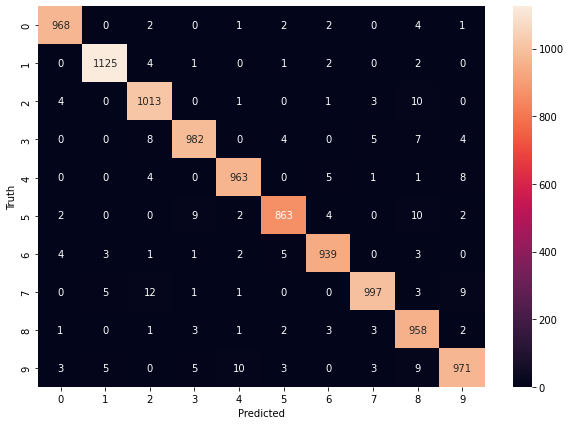

In [7]:
y_predicted = model.predict(X_test_flattened)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
y_predicted_labels[:5]

#Confusion Matrix
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted_labels)

#Plot Confusion Matrix
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [8]:
model.save("./saved_model")

INFO:tensorflow:Assets written to: ./saved_model/assets


#Post Training Quantization

In [9]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

In [10]:
len(tflite_model)

319484

##With Quantization

In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quant_model = converter.convert()

In [12]:
len(tflite_quant_model)

84432

In [13]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

#Quantization Aware Training

In [20]:
!pip install tensorflow_model_optimization

import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

q_aware_model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (QuantizeL  (None, 784)              3         
 ayer)                                                           
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1015      
 perV2)                                                          
                                                                 
Total params: 79,523
Trainable params: 79,510
Non-trainable params: 13
_________________________________________________________________


In [21]:
q_aware_model.fit(X_train_flattened, y_train, epochs = 5) #here training happen

Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0433 - accuracy: 0.9872
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0348 - accuracy: 0.9892
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0278 - accuracy: 0.9913
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0235 - accuracy: 0.9929
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0195 - accuracy: 0.9937


In [23]:
q_aware_model.evaluate(X_test_flattened, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.0944 - accuracy: 0.9737


[0.09444695711135864, 0.9736999869346619]

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp5t6jxc7_/assets


INFO:tensorflow:Assets written to: /tmp/tmp5t6jxc7_/assets


In [25]:
with open("tflite_qaware_model.tflite", "wb") as f:
    f.write(tflite_qaware_model)